In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from nltk.tokenize import word_tokenize

In [2]:
# Loading custom defined functions
from tokenization import tokenize_sentence_nltk, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, postprocess_sentences, get_redundaunt_info
from util import filter_data, filter_senders, filter_recipients, search_patterns
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model, run_aff_prop_with_distances, run_kmeans
from nltk.stem import WordNetLemmatizer
from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model
from util import get_semantic_similarity, get_character_similarity
from lemmatization import lemmatize_treetagger
from util import run_treetagger, join_tokens, parse_date, is_spelled_correctly
from json import load

In [3]:
DetectorFactory.seed = 0

in_file = load(open("in_file.cfg", 'r'))
patterns_file = in_file["patterns_file"]
file_folder = in_file["file_folder"]
label = in_file["label"]
column = in_file["column"]
in_type = in_file["in_type"]
in_file = in_file["in_file"]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html_chat":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    strings = read_folder(in_file, in_type = in_type)

patterns = Series([".*" + x + ".*" for x in open(patterns_file, 'r').readlines()])

# For html_chat:
# strings -> DataFrame; meta_data -> Series; timestamp -> Series

# For csv, html_email, enron_email:
# strings -> DataFrame

# For folder:
# Sames as file

# html_email and enron_email will have columns 'conversation' (string) and 'meta_data' (dictionary)

# html_chat will have columns "itemId", "messageType", "messageDirection", "case", "captureDate", "policyAction", "statusMarkDate", "status", "status_reviewer", "commentDate", "comment", "comment_reviewer", "participants", "timestamp", "language", "sender", "recipients", "subject", "conversation", "num_of_conversation_turns" and "messages"

In [4]:
if in_type == "html_email" or in_type == "enron_email":
    conv = strings["conversation"].apply(tokenize_sentence_nltk)
    strings = strings["meta_data"].apply(Series)
    strings["conversation"] = conv
    try:
        strings["Sent"] = strings["Sent"].apply(parse_date)
    except:
        pass
    try:
        # 1900/01/01 00:00:00 is equivalent to NULL
        strings["Date"] = strings["Date"].apply(parse_date) # This is time consuming function, but it is robust
    except:
        pass

# For html_email, enron_email ->
# 1) tokenize the strings to create list of sentences
# 2) convert meta data from dictionary to columns
# 3) parse "Sent" and "Date" columns from string to datetime.datetime (1900-01-01 00:00:00 is equivalent to NULL)

In [5]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,[Please let me know if you still need Curve Sh...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., Did you attach the file t..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., This is exactly what we n..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/18, 1/31..."


In [6]:
if in_type == "html_chat":
    redundant = get_redundaunt_info(strings)
    total_redundant = redundant.sum()
    from re import findall
    unnecessary1 = strings['sender'].apply(lambda x: len(findall("^gg.*", x.lower())) > 0)
    unnecessary2 = strings['participants'].apply(lambda x: sum([len(findall("^gg.*|\;gg.*", y)) for y in x]) > 0)
    unnecessary = unnecessary1 | unnecessary2
    total_unnecessary = unnecessary.sum()
    # Deduplication
    strings = filter_senders(strings)
    strings.head()
    strings = filter_recipients(strings)
    strings.head()
    strings = filter_data(strings)
    strings.head()
    strings1 = strings.drop(['messages'], axis = 1).reset_index(drop = True)
    strings = strings['messages'].reset_index(drop = True)
    strings = strings.apply(lambda x: " ".join(x))

# For html_chat ->
# Remove unnecessary chat history: gg.* is the pattern for unwanted senders/participants
# Remove duplicate chats
# strings1 is a DataFrame with all columns except 'messages'
# strings is a Series (string) which is used for downstream NLP

In [7]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,[Please let me know if you still need Curve Sh...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., Did you attach the file t..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., This is exactly what we n..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/18, 1/31..."


In [8]:
try:
    strings = strings["conversation"]
except:
    pass

strings = strings.apply(postprocess_sentences)

# For html_email and enron_email -> pick conversation column for downstream NLP

In [9]:
# Identifying keyword hits
hits = strings.apply(lambda x: search_patterns(x, patterns))
hits['any'] = hits.apply(sum, axis = 0)
hit_strings = strings[hits['any'] > 0]

# Pattern matching -> store in 'hits' if any of the string patterns match

In [10]:
# Language filter for downstream NLP
languages = strings.apply(detect_language)

# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
# labels = labels[english_only].tolist()

# Retain only English text in strings
# labels is for supervised learning (future use)

In [11]:
# Processing English sentences:
# 1) Tokenization
sentences = strings.apply(tokenize_treetagger)
lengths = sentences.apply(len)

# new_labels = []
# for i in range(len(lengths)):
#     for j in range(lengths[i]):
#         new_labels.append(labels[i])
# new_labels = Series(new_labels)
# sentences1 = flatten_list_of_list(sentences)

# sentences -> list of (list for tokens) -> outer list: one list per sentence

In [12]:
sentences = sentences[lengths > 0]

# lengths -> used to remove sentences that are not tokenized

In [13]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = sentences.apply(lambda x: join_tokens(x))
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

# sentences1 -> tokens joined back into single string with '. ' separating sentences
# pos -> DataFrame with part-of-speech of sentences1

In [14]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
# inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
# labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

# lengths -> used to remove sentences for which pos is not tagged
# sentences_tokens -> combine words in pos if: a) word and adjacent word are incorrectly spelled, b) combination of words is correctly spelled

In [15]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

# trigrams -> Series of lists: unigrams, bigram phrases (word1_word2) and trigram phrases (word1_word2_word3)

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [16]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+lemmatize_treetagger(run_treetagger(i.lower())) if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
# labels = labels.tolist() + inc_labels.tolist()

# Join the sentences back
# sentences1 -> list of strings

In [17]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "")+"\n")

out_file.close()

# sentences1 written to text file "sample.txt" for word2vec and LDA models

In [18]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

# Build word2vec model on "sample.txt" and save model to "big.w2v"

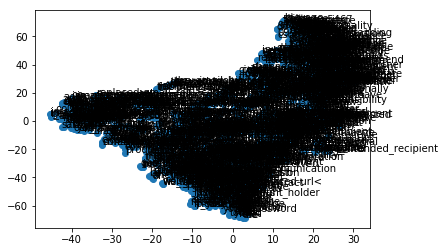

In [19]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

# Visualize word2vec model in 2d using t-SNE

In [20]:
# 9) Setting up the data for building logistic regression model
#df = zeros((len(sentences1), 100))
#for i, words in enumerate(trigrams):
#    for word in words:
#        try:
#            df[i] = df[i] + model[word]
#        except:
#            continue

#while(i<len(sentences1)):
#    i += 1
#
#df = DataFrame(df)
#df[label] = labels

# This is for building supervised learning model using sentence embeddings as predictors

In [21]:
# 10) Building and saving the logistic regression model with L1 penalty
#lr_model = build_logistic_regression(df, label)
#dump(lr_model, open("logistic_model.pkl", 'wb'))

# Build and dump the model

In [22]:
# 11) Topic modeling (Optional)
#lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
#lda_model.print_topic(1)

In [23]:
sim1 = get_semantic_similarity(model)

# Get m x m matrix of semantic (cosine) similarity between words in vocabulary

In [24]:
vocab = list(model.wv.vocab)

# Get all m words in vocabulary

In [25]:
# ratio = get_character_similarity(vocab, 'ratio')

# Compute m x m character-based similarity metric between words in vocabulary

In [26]:
# partial_ratio = get_character_similarity(vocab, "partial_ratio")

In [27]:
# token_sort_ratio = get_character_similarity(vocab, "token_sort_ratio")

In [28]:
# token_set_ratio = get_character_similarity(vocab, "token_set_ratio")

In [29]:
sim1 = sim1[ratio.columns]
sim1 = sim1.loc[ratio.columns]

# sim1 is m x m matrix

In [30]:
# semantic_weight = 0.5
# ratio_weight = 0.4
# partial_ratio_weight = 0.4
# token_sort_ratio_weight = 0.1
# sim = semantic_weight*sim1 + (ratio_weight*ratio + partial_ratio_weight*partial_ratio + token_sort_ratio_weight*token_sort_ratio + (1-ratio_weight-partial_ratio_weight-token_sort_ratio_weight)*token_set_ratio)*(1-semantic_weight)
# dist = 1 - sim

# Currently heuristic weights are assigned for different similarities
# dist is m x m matrix

In [31]:
# aff = run_aff_prop_with_distances(dist)

# Run affinity propagation model on computed composite distance matrix and store in aff

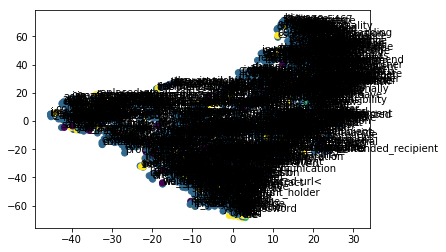

In [32]:
# visualize_word2vec_model(model, aff.labels_)

# Visualize word2vec model with labels as per affinity propagation clusters

In [33]:
# columns = sim.columns
# condition = Series(sim.columns).apply(is_spelled_correctly)
# sim = sim.loc[columns[~condition]]
# sim = sim[columns[condition]]

# Identify mis-spelled words and find nearest words; words with '_' are also considered correct (this needs some thought)

In [34]:
# sim.apply(lambda x: x.sort_values().index[0], axis = 1)

0                  replaced-email_replaced-email_
0.00               replaced-email_replaced-email_
0.030              replaced-email_replaced-email_
0.65               replaced-email_replaced-email_
00                 replaced-email_replaced-email_
000                replaced-email_replaced-email_
000000000067320    replaced-email_replaced-email_
001                replaced-email_replaced-email_
00pm               replaced-email_replaced-email_
01                 replaced-email_replaced-email_
02                 replaced-email_replaced-email_
03                 replaced-email_replaced-email_
04                                             be
05                                             be
06                 replaced-email_replaced-email_
07                 replaced-email_replaced-email_
08                                             be
081                replaced-email_replaced-email_
09                                             be
096                replaced-email_replaced-email_


In [35]:
df = DataFrame(model.wv[model.wv.vocab])
df.columns = ['c' + str(i) for i in range(df.shape[1])]
km = run_kmeans(model.wv[model.wv.vocab])

# Run kmeans model and store in km object

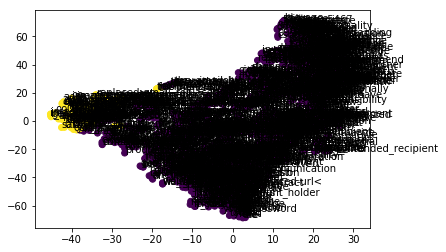

In [36]:
visualize_word2vec_model(model, km.cluster)

# Visualize word2vec with kmeans cluster labels

In [37]:
lda_model, corpus, dictionary = run_lda_topic_model(text_file = "sample.txt")

# Run gensim LDA model on "sample.txt" and return model (lda_model), corpus (corpus) and dictionary (dictionary)

In [38]:
lda_model.print_topics(-1)

# Prints all topics

[(0,
  '0.024*"gas" + 0.012*"ngi" + 0.012*"price" + 0.012*"e-mail" + 0.012*"weekly" + 0.011*"please" + 0.011*"your_password" + 0.011*"replaced-url_replaced-url" + 0.011*"newsletter" + 0.010*"intelligence"'),
 (1,
  '0.007*"enron" + 0.007*"replaced-email_replaced-email" + 0.006*"scenario" + 0.005*"kirk" + 0.005*"script" + 0.005*"comment" + 0.004*"theme" + 0.004*"rm" + 0.004*"review" + 0.004*"use"'),
 (2,
  '0.017*"please" + 0.015*"lexis-nexis" + 0.015*"basic" + 0.014*"00" + 0.013*"learn" + 0.012*"information" + 0.011*"interactive" + 0.010*"november" + 0.010*"training" + 0.010*"attend"'),
 (3,
  '0.010*"please" + 0.009*"your_password" + 0.008*"account" + 0.007*"information" + 0.007*"use" + 0.006*"call" + 0.006*"e-mail" + 0.005*"ibs" + 0.005*"process" + 0.005*"if_you"'),
 (4,
  '0.016*"post" + 0.013*"office" + 0.010*"phillip" + 0.009*"like" + 0.009*"look" + 0.008*"time" + 0.007*"n\'t" + 0.007*"year" + 0.007*"repair" + 0.007*"return"'),
 (5,
  '0.025*"503" + 0.024*"report" + 0.022*"gen" + 

In [39]:
from util import get_word_lda_topics
Series(list(model.wv.vocab.keys())).apply(lambda x: get_word_lda_topics(x))

# Supposed to get list of all topics for each word in vocab -> not working for some reason (returns None)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
1404    None
1405    None
1406    None
1407    None
1408    None
1409    None
1410    None
1411    None
1412    None
1413    None
1414    None
1415    None
1416    None
1417    None
1418    None
1419    None
1420    None
1421    None
1422    None
1423    None
1424    None
1425    None
1426    None
1427    None
1428    None
1429    None
1430    None
1431    None
1432    None
1433    None
Length: 1434, dtype: object

In [40]:
from visualizing import visualize_lda_topics
visualize_lda_topics(lda_model, corpus, dictionary)

# Visualize LDA model using MDS

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
71     6.817987        1       1  0.142852  0.186907
97     6.108542        1       2 -0.014258 -0.117465
79     5.950577        1       3  0.111765 -0.025229
25     5.040798        1       4 -0.269474  0.181074
30     4.730191        1       5 -0.085359 -0.124283
21     3.510389        1       6 -0.053586 -0.037695
78     3.494865        1       7  0.152070  0.076305
47     3.289193        1       8 -0.069670 -0.023455
65     3.277819        1       9  0.055433  0.174467
51     3.166504        1      10  0.022616 -0.102859
28     2.981541        1      11 -0.265996  0.136477
57     2.580187        1      12  0.073177  0.004396
93     2.552628        1      13 -0.016386 -0.026177
35     2.521704        1      14  0.147123  0.024670
7      2.466521        1      15  0.019993 -0.091069
81     2.461642        1      16 -0.066669  0.040211
76     2.319180        1      17 -0.074474  0.042972
69     2.224703        1      18  0.105377  0.040372
74     2.016301        1      19  0.112427  0.119487
36     2.015114        1      20  0.013801  0.085846
84     1.990138        1      21  0.105377  0.021091
94     1.739669        1      22  0.079585  0.068846
31     1.706248        1      23  0.013680 -0.044964
29     1.682387        1      24  0.037181  0.096379
98     1.637649        1      25  0.050411  0.069172
4      1.603898        1      26  0.028782 -0.064378
67     1.550605        1      27 -0.114733  0.024741
41     1.491666        1      28  0.002157  0.001472
15     1.485118        1      29 -0.004973  0.019923
53     1.287203        1      30 -0.016279  0.036242
...         ...      ...     ...       ...       ...
8      0.008436        1      71 -0.011656 -0.021354
6      0.008436        1      72  0.009545 -0.024108
3      0.008436        1      73  0.095546  0.026336
1      0.008436        1      74  0.002451  0.009706
10     0.008436        1      75 -0.004460 -0.128450
49     0.008436        1      76  0.008362  0.006311
24     0.008436        1      77 -0.152713  0.137570
33     0.008436        1      78  0.004896  0.002870
95     0.008436        1      79  0.062967 -0.003772
87     0.008436        1      80 -0.129155 -0.010270
83     0.008436        1      81 -0.005084 -0.046988
82     0.008436        1      82  0.049382  0.037043
75     0.008436        1      83 -0.092216  0.057126
73     0.008436        1      84  0.028907  0.093760
72     0.008436        1      85 -0.089615 -0.104049
66     0.008436        1      86 -0.160335 -0.039650
63     0.008436        1      87  0.065675  0.083815
62     0.008436        1      88 -0.014596 -0.073987
61     0.008436        1      89 -0.013447 -0.003367
59     0.008436        1      90  0.059507  0.066802
56     0.008436        1      91 -0.039441 -0.037456
52     0.008436        1      92 -0.008229 -0.005097
50     0.008436        1      93  0.038527 -0.014835
48     0.008436        1      94  0.032192  0.110498
45     0.008436        1      95  0.008040 -0.106845
39     0.008436        1      96  0.003972 -0.011692
38     0.008436        1      97 -0.125419 -0.000789
37     0.008436        1      98 -0.029402 -0.087108
34     0.008436        1      99 -0.009453 -0.108645
0      0.008436        1     100  0.062772 -0.011259

[100 rows x 5 columns], topic_info=      Category       Freq                             Term      Total  \
term                                                                    
55     Default  57.000000                             2001  57.000000   
43     Default  44.000000        replaced-url_replaced-url  44.000000   
249    Default  44.000000    replaced-email_replaced-email  44.000000   
302    Default  32.000000          image_image_image_image  32.000000   
891    Default  35.000000                               09  35.000000   
319    Default  35.000000                            image  35.000000   
244    Def

In [42]:
from sentiment_analysis import tag_sentiment_nltk
from util import get_sentiment_with_highest_score

In [43]:
Series(sentences1).apply(tag_sentiment_nltk).apply(get_sentiment_with_highest_score)

# Tag sentiments and return sentiment with highest probability

0     neu
1     neu
2     neu
3     neu
4     neu
5     neu
6     neu
7     neu
8     neu
9     neu
10    neu
11    neu
12    neu
13    neu
14    neu
15    neu
16    neu
17    neu
18    neu
19    neu
20    neu
21    neu
22    neu
23    neu
24    neu
25    neu
26    neu
27    neu
28    neu
29    neu
     ... 
47    neu
48    neu
49    neu
50    neu
51    neu
52    neu
53    neu
54    neu
55    neu
56    neu
57    neu
58    neu
59    neu
60    neu
61    neu
62    neu
63    neu
64    neu
65    neu
66    neu
67    neu
68    neu
69    neu
70    neu
71    neu
72    neu
73    neu
74    neu
75    neu
76    neu
Length: 77, dtype: object

In [44]:
from sentiment_analysis import tag_sentiment_stanfordcorenlp
tag_sentiment_stanfordcorenlp(sentences1[0])

['Positive']

In [48]:
sentences1[0]

'please_let_me_know if_you still need curve shift thanks heather'

In [47]:
tag_sentiment_stanfordcorenlp(" ".join(sentences[0]))

['Positive']

In [49]:
" ".join(sentences[0])

'please let me know if you still need curve shift     thanks     heather'